In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from synthetic import simulate_var
from models.cmlp_new import cMLP, cMLPSparse, train_model_ista, train_unregularized, train_model_adam

device = torch.device('cuda')

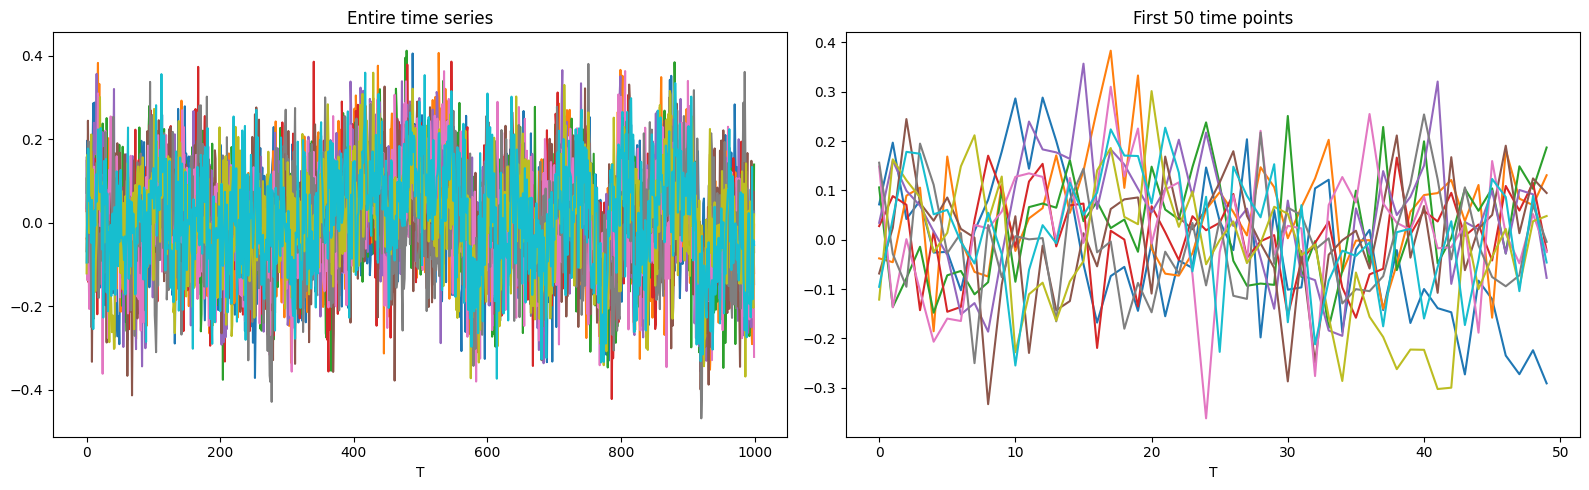

torch.Size([1, 1000, 10])


In [2]:
X_np, beta, GC = simulate_var(p=10, T=1000, lag=3)
X = torch.tensor(X_np[np.newaxis], dtype=torch.float32, device=device)


fig, axarr = plt.subplots(1, 2, figsize=(16, 5))
axarr[0].plot(X_np)
axarr[0].set_xlabel('T')
axarr[0].set_title('Entire time series')
axarr[1].plot(X_np[:50])
axarr[1].set_xlabel('T')
axarr[1].set_title('First 50 time points')
plt.tight_layout()
plt.show()
print(X.shape)

In [3]:
cmlp = cMLP(X.shape[-1], lag=5, hidden=[100]).cuda()

In [4]:
train_loss_list = train_model_ista(
    cmlp, X, lam=0.002, lam_ridge=1e-2, lr=5e-2, penalty='HD', max_iter=50000,
    check_every=100)

----------Iter = 100----------
Loss = 0.052680
Variable usage = 100.00%
----------Iter = 200----------
Loss = 0.051562
Variable usage = 100.00%
----------Iter = 300----------
Loss = 0.050546
Variable usage = 100.00%
----------Iter = 400----------
Loss = 0.049808
Variable usage = 100.00%
----------Iter = 500----------
Loss = 0.049223
Variable usage = 100.00%
----------Iter = 600----------
Loss = 0.048739
Variable usage = 100.00%
----------Iter = 700----------
Loss = 0.048324
Variable usage = 100.00%
----------Iter = 800----------
Loss = 0.047959
Variable usage = 100.00%
----------Iter = 900----------
Loss = 0.047632
Variable usage = 100.00%
----------Iter = 1000----------
Loss = 0.047333
Variable usage = 100.00%
----------Iter = 1100----------
Loss = 0.047057
Variable usage = 100.00%
----------Iter = 1200----------
Loss = 0.046798
Variable usage = 100.00%
----------Iter = 1300----------
Loss = 0.046553
Variable usage = 100.00%
----------Iter = 1400----------
Loss = 0.046319
Variable usa

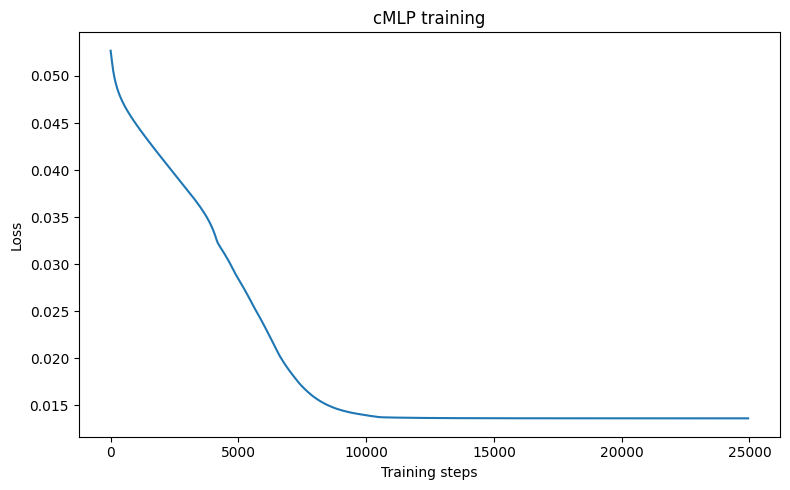

In [5]:
plt.figure(figsize=(8, 5))
plt.plot(50 * np.arange(len(train_loss_list)), train_loss_list)
plt.title('cMLP training')
plt.ylabel('Loss')
plt.xlabel('Training steps')
plt.tight_layout()
plt.show()

In [13]:
Train_loss_list_np = np.array(train_loss_list)
GC_est = cmlp.GC().cpu().data.numpy()
GC_est_lag_total = cmlp.GC(ignore_lag=False, threshold=False).cpu().data.numpy()
np.savez('./result_record/result_var3-0-2-0-1000_drmlpnolstms-2e-31e-25e-2HD100_file.npz', Train_loss_list_np, GC, GC_est, GC_est_lag_total)

print('True variable usage = %.2f%%' % (100 * np.mean(GC)))
print('Estimated variable usage = %.2f%%' % (100 * np.mean(GC_est)))
print('Accuracy = %.2f%%' % (100 * np.mean(GC == GC_est)))

True variable usage = 20.00%
Estimated variable usage = 20.00%
Accuracy = 100.00%


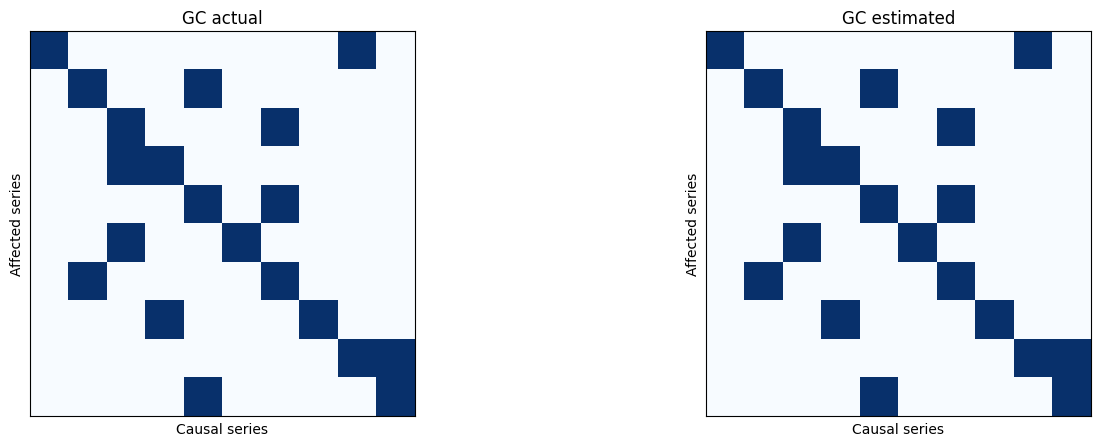

In [7]:
# Make figures
fig, axarr = plt.subplots(1, 2, figsize=(16, 5))
axarr[0].imshow(GC, cmap='Blues')
axarr[0].set_title('GC actual')
axarr[0].set_ylabel('Affected series')
axarr[0].set_xlabel('Causal series')
axarr[0].set_xticks([])
axarr[0].set_yticks([])

axarr[1].imshow(GC_est, cmap='Blues', vmin=0, vmax=1, extent=(0, len(GC_est), len(GC_est), 0))
axarr[1].set_title('GC estimated')
axarr[1].set_ylabel('Affected series')
axarr[1].set_xlabel('Causal series')
axarr[1].set_xticks([])
axarr[1].set_yticks([])

# Mark disagreements
for i in range(len(GC_est)):
    for j in range(len(GC_est)):
        if GC[i, j] != GC_est[i, j]:
            rect = plt.Rectangle((j, i-0.05), 1, 1, facecolor='none', edgecolor='red', linewidth=1)
            axarr[1].add_patch(rect)

plt.show()

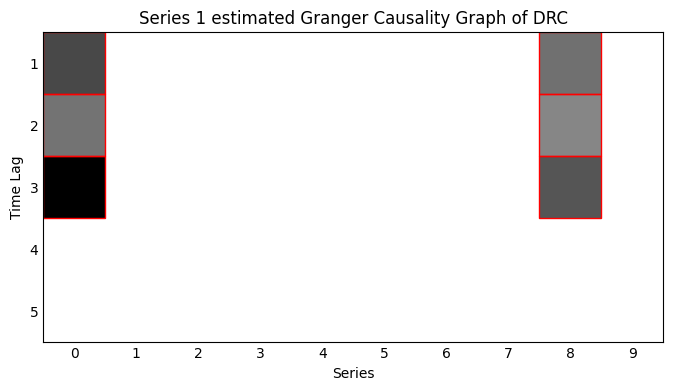

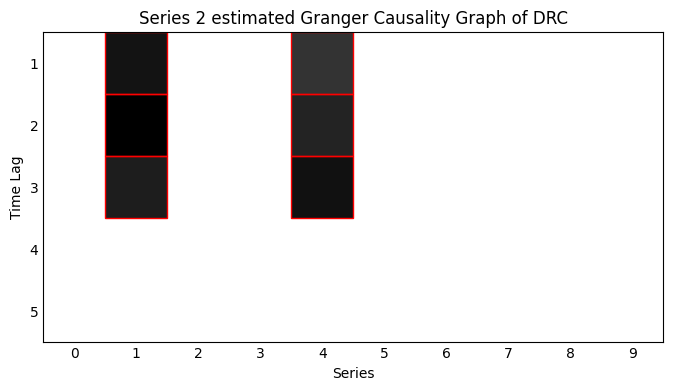

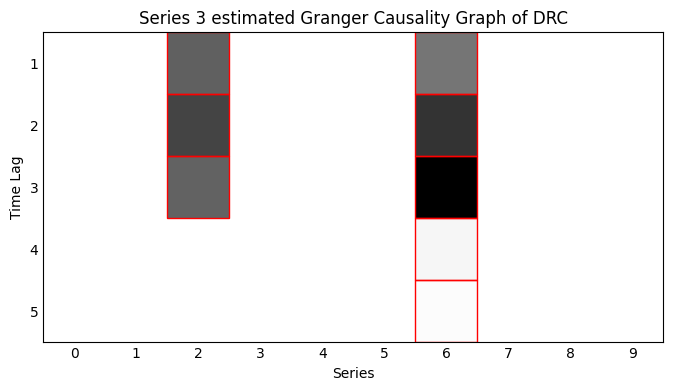

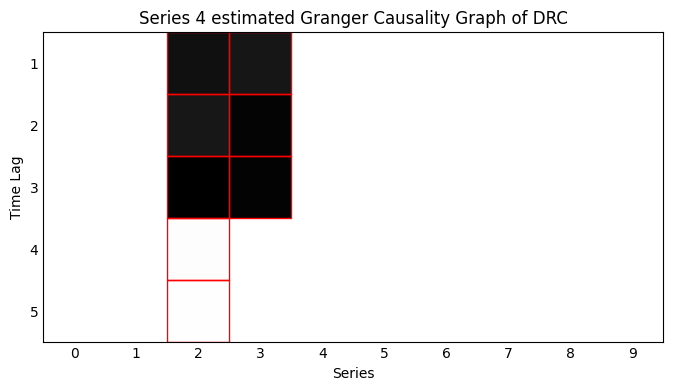

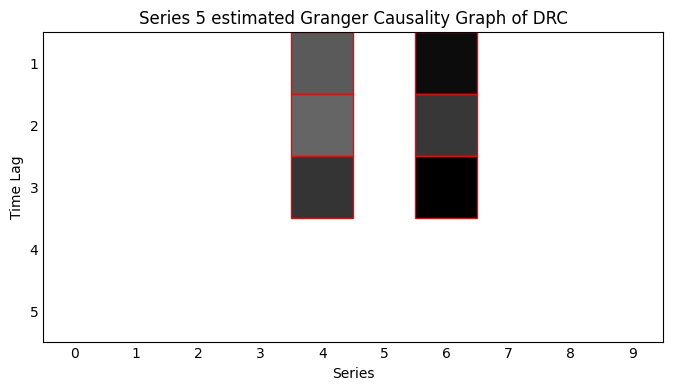

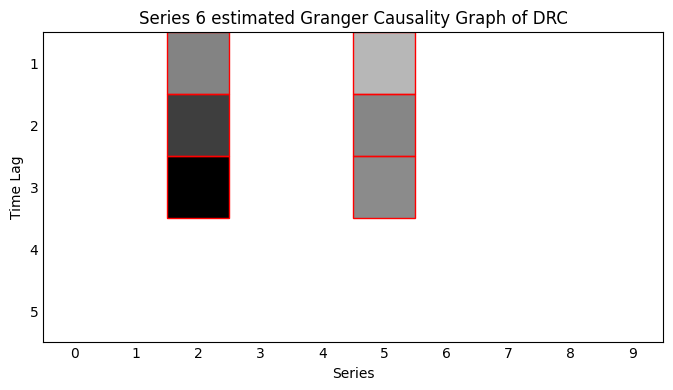

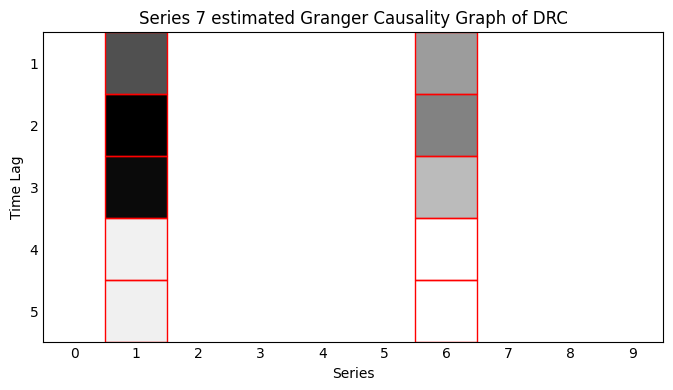

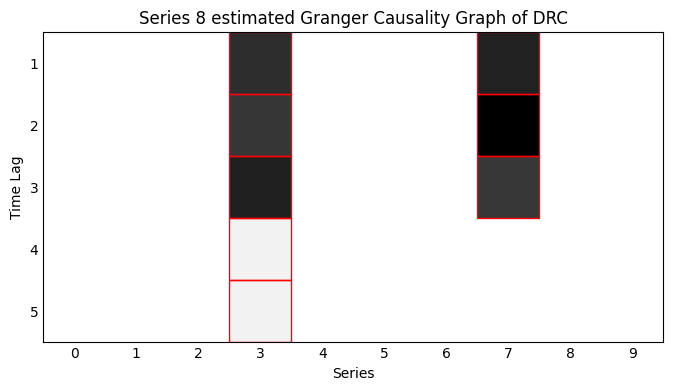

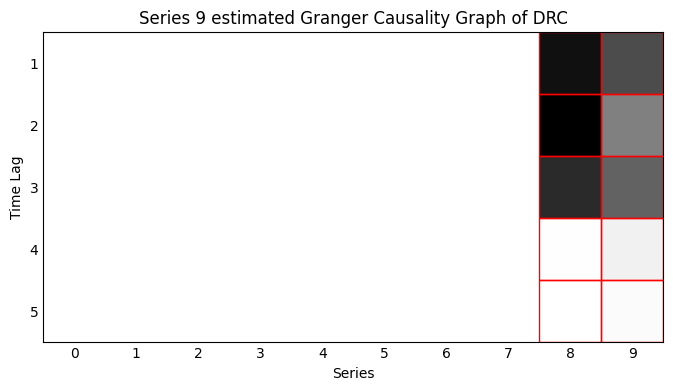

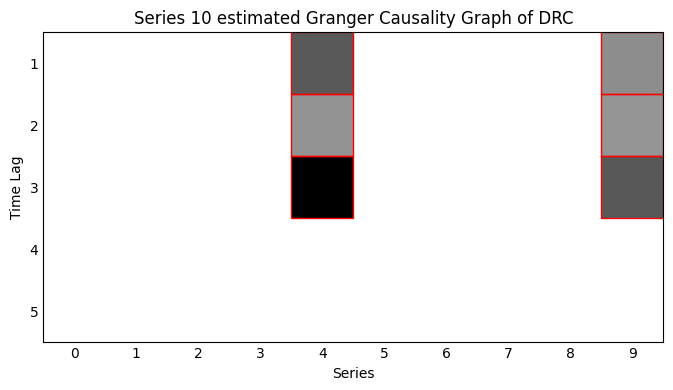

In [11]:
# Verify lag selection
for i in range(len(GC_est)):
    # Get true GC
    GC_lag = np.zeros((5, len(GC_est)))
    GC_lag[:3, GC[i].astype(bool)] = 1.0

    # Get estimated GC
    GC_est_lag = cmlp.GC(ignore_lag=False, threshold=False)[i].cpu().data.numpy().T[::-1]

    # Make figures
    # fig, axarr = plt.subplots(1, 2, figsize=(16, 5))
    # axarr[0].imshow(GC_lag, cmap='Blues', extent=(0, len(GC_est), 5, 0))
    # axarr[0].set_title('Series %d true GC' % (i + 1))
    # axarr[0].set_ylabel('Lag')
    # axarr[0].set_xlabel('Series')
    # axarr[0].set_xticks(np.arange(len(GC_est)) + 0.5)
    # axarr[0].set_xticklabels(range(len(GC_est)))
    # axarr[0].set_yticks(np.arange(5) + 0.5)
    # axarr[0].set_yticklabels(range(1, 5 + 1))
    # axarr[0].tick_params(axis='both', length=0)

    # axarr[1].imshow(GC_est_lag, cmap='Blues', extent=(0, len(GC_est), 5, 0))
    # axarr[1].set_title('Series %d estimated GC' % (i + 1))
    # axarr[1].set_ylabel('Lag')
    # axarr[1].set_xlabel('Series')
    # axarr[1].set_xticks(np.arange(len(GC_est)) + 0.5)
    # axarr[1].set_xticklabels(range(len(GC_est)))
    # axarr[1].set_yticks(np.arange(5) + 0.5)
    # axarr[1].set_yticklabels(range(1, 5 + 1))
    # axarr[1].tick_params(axis='both', length=0)

    # # Mark nonzeros
    # for i in range(len(GC_est)):
    #     for j in range(5):
    #         if GC_est_lag[j, i] > 0.0:
    #             rect = plt.Rectangle((i, j), 1, 1, facecolor='none', edgecolor='green', linewidth=1.0)
    #             axarr[1].add_patch(rect)

    # plt.show()

    plt.figure(figsize=(8, 5))
    ax = plt.gca()
    ax.imshow(GC_est_lag, cmap='Greys', extent=(0, len(GC_est), 5, 0))
    ax.set_title('Series %d estimated Granger Causality Graph of DRC' % (i + 1))
    ax.set_ylabel('Time Lag')
    ax.set_xlabel('Series')
    ax.set_xticks(np.arange(len(GC_est)) + 0.5)
    ax.set_xticklabels(range(len(GC_est)))
    ax.set_yticks(np.arange(5) + 0.5)
    ax.set_yticklabels(range(1, 5 + 1))
    ax.tick_params(axis='both', length=0)

    for k in range(len(GC_est)):
        for j in range(5):
            if GC_est_lag[j, k] > 0.0:
                rect = plt.Rectangle((k, j), 1, 1, facecolor='none', edgecolor='red', linewidth=1.0)
                ax.add_patch(rect)
    plt.savefig('./imgs/DRC_var3_0_img{}.tiff'.format(i), dpi=600)